# Import Libraries

In [1]:
from keras import layers
from keras import models
import keras as k
import sys
import matplotlib.pyplot as plt
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import os

%matplotlib inline

print('Keras Version: ', k.__version__)
print('Python Verson: ', sys.version)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Keras Version:  2.1.6
Python Verson:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


# First Model

Now that we have our dependencies imported we can build our first convolusional neural network to establish a baseline in our quest to identify cats vs dogs

In [2]:
def four_layer_cnn(dropout=False, lr=1e-4, loss='binary_crossentropy', metrics=['acc']):
    """
    Utility function to create and compile a four layer convolutional neural network with 
    relu activations at each hidden layer and a sigmoid activation at the output layer

    Inputs: selection of hyperparameters for configuring the model, including dropout, learning rate, loss, and metrics
    Outputs: a compiled model with the hyperparameters set according to input values
    """
        
    # Start with a sequential model instance
    model = models.Sequential()

    # Add convolutional layers with relu activation and maxpooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer and add dropout (if applicable)
    model.add(layers.Flatten())
    
    if dropout:
        model.add(layers.Dropout(0.5))
        
    # Add dense layer and final output layer with a single value output between 0-1
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model after all layers have been added using the hyperparameters entered in the function
    model.compile(loss=loss,
                 optimizer=optimizers.RMSprop(lr=lr),
                  metrics=metrics)
    
    print('Dropout: {}'.format(dropout)) 
    print('Learning rate: {}'.format(lr))
    print('Loss: {}'.format(loss))
    print('Success metrics: {}'.format(','.join(metrics)))
    print(model.summary())
    
    return model

In [3]:
model_without_dropout = four_layer_cnn(dropout=False)

Dropout: False
Learning rate: 0.0001
Loss: binary_crossentropy
Success metrics: acc
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
__________________________________________________________

## Data Generator

We have to create generators to fetch our data which we've downloaded from Kaggle and processed in the other notebook called *'Import Images'*

In [7]:
def fetch_train_val_test_dir(base_directory):
    # Define data directories from import notebook
    base_dir = base_directory

    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    return train_dir, validation_dir, test_dir

In [8]:
train_dir, validation_dir, test_dir = fetch_train_val_test_dir('/home/ubuntu/deep-learning-practice/data/cats_dogs_small')

In [9]:
def create_train_validation_generators(train_dir, validation_dir, augmentation=False):
    """Wrapper function to create train_generator and validation generator with or without augmentation as indicated in parameter"""
    
    if augmentation:
        train_datagen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)
        
    else: 
        train_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
    
    # Print shape of data 
    for data_batch, labels_batch in train_generator:
        print('data batch shape: ', data_batch.shape)
        print('labels batch shape: ', labels_batch.shape)
        break
        
    return train_generator, validation_generator


In [10]:
train_generator, validation_generator = create_train_validation_generators(train_dir=train_dir, validation_dir=validation_dir)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape:  (20, 150, 150, 3)
labels batch shape:  (20,)


Now that we have our data generator for both the training and validation set we want to use we can train our little model and see how the loss from our validation and training sets track over time. This can give us a sense of how well our model is learning the patterns in the training set or if it is overfitting to the noise. 

In [13]:
def train_save_model(model, train_generator, validation_generator, steps_per_epoch, epochs):
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=50)
    
    model.save('cats_and_dogs_small_1.h5')
    
    plot_model_performance(history)
    
    return history

Epoch 1/15
100/100 [==============================] - 96s 964ms/step - loss: 0.6817 - acc: 0.5470 - val_loss: 0.6644 - val_acc: 0.5980
Epoch 2/15
100/100 [==============================] - 96s 961ms/step - loss: 0.6318 - acc: 0.6385 - val_loss: 0.6622 - val_acc: 0.6190
Epoch 3/15
100/100 [==============================] - 96s 959ms/step - loss: 0.5774 - acc: 0.7020 - val_loss: 0.7512 - val_acc: 0.5880
Epoch 4/15
100/100 [==============================] - 96s 960ms/step - loss: 0.5531 - acc: 0.7125 - val_loss: 0.6302 - val_acc: 0.6540
Epoch 5/15
100/100 [==============================] - 96s 956ms/step - loss: 0.5259 - acc: 0.7285 - val_loss: 0.5821 - val_acc: 0.6850
Epoch 6/15
100/100 [==============================] - 95s 955ms/step - loss: 0.4926 - acc: 0.7610 - val_loss: 0.5761 - val_acc: 0.6880
Epoch 7/15
100/100 [==============================] - 94s 940ms/step - loss: 0.4701 - acc: 0.7795 - val_loss: 0.5970 - val_acc: 0.6990
Epoch 8/15
100/100 [==============================] - 9

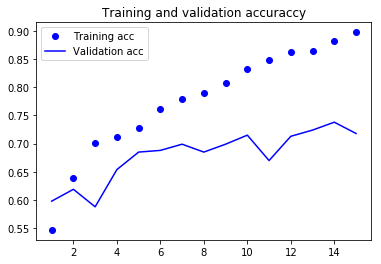

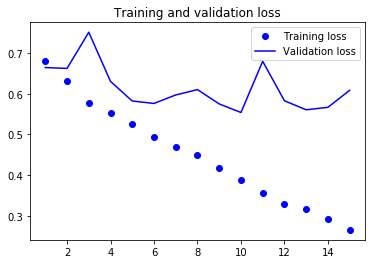

In [14]:
history = train_save_model(model=model_without_dropout, train_generator=train_generator,
                          validation_generator=validation_generator, steps_per_epoch=100, epochs=15)

This took about a minute per epoch to train... so around 30 minutes for the whole thing when run on a GPU in AWS. I imagine this would take much longer if run locally on my CPU. 

Now that we have all data for our plots we can visually inspect how well our validation error is in keeping with our trianing error. In cases where the training error continues to increase with every epoch but the validation error plateaus, we know that our model is overfitting to the training data and not generalizing well to new data (aka, the validation set). 

In [11]:
def plot_model_performance(history):
    '''Pass in the model performance history to 
        parse out the accuraccy and loss and plot training and validation metrics'''
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuraccy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show();

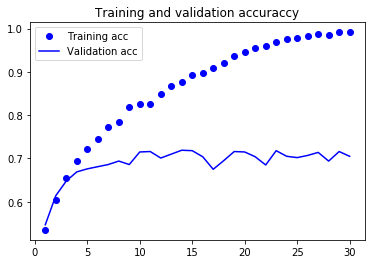

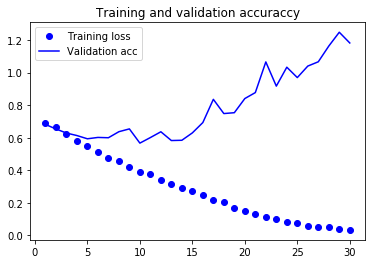

In [24]:
plot_model_performance(history)

Yikes!! It looks like the model is severely overfitting to the training data as the validation loss stops decreasing after about 5 epochs

## Data Augmentation

Data augmentation is one way to combate overfitting because it will create new, slightly adjusted images for the training set to use!

In [25]:
from keras.preprocessing import image
import os

In [26]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [50]:
train_cats_dir = os.path.join(train_dir, 'cats')
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[60]

img = image.load_img(img_path, target_size=(150, 150))

In [51]:
x = image.img_to_array(img)
print(x.shape)

x = x.reshape((1,) + x.shape)
print(x.shape)

(150, 150, 3)
(1, 150, 150, 3)


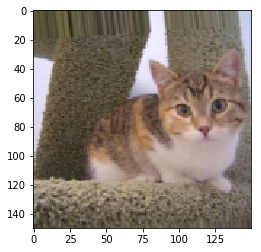

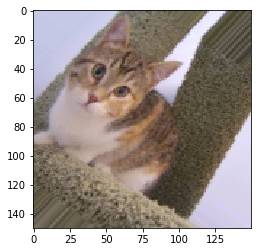

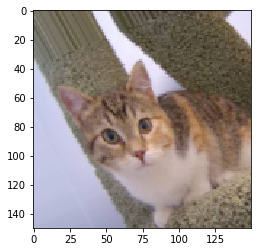

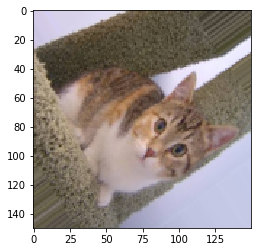

In [56]:
i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

## Model with Augmented Data

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 93s 929ms/step - loss: 0.6926 - acc: 0.5325 - val_loss: 0.6678 - val_acc: 0.6010
Epoch 2/30
100/100 [==============================] - 91s 914ms/step - loss: 0.6759 - acc: 0.5740 - val_loss: 0.6543 - val_acc: 0.6210
Epoch 3/30
100/100 [==============================] - 92s 921ms/step - loss: 0.6641 - acc: 0.5760 - val_loss: 0.6315 - val_acc: 0.6390
Epoch 4/30
100/100 [==============================] - 91s 915ms/step - loss: 0.6501 - acc: 0.6055 - val_loss: 0.6307 - val_acc: 0.6220
Epoch 5/30
100/100 [==============================] - 92s 923ms/step - loss: 0.6329 - acc: 0.6210 - val_loss: 0.5999 - val_acc: 0.6780
Epoch 6/30
100/100 [==============================] - 92s 916ms/step - loss: 0.6161 - acc: 0.6530 - val_loss: 0.6075 - val_acc: 0.6630
Epoch 7/30
100/100 [==============================] - 92s 921ms/step - loss: 0.6057 - acc: 0.6595 - val_loss: 0.5933 - val_acc: 0.6890
Epoch 8/30
100/100 [==============================] - 9

In [30]:
model.save('cats_and_dogs_small_2.h5')

In [11]:
def plot_model_performance(history):
    '''Pass in the model performance history to 
        parse out the accuraccy and loss and plot training and validation metrics'''
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuraccy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show();
    

In [ ]:
plot_model_performance(history)

Great! We've fixed the overfitting problem we saw in the first model but the best accuracy we can get after 30 epochs is around 75%. This is still better than the highest validation accuracy we saw after 30 epochs without any data augmentation (.7)

Let's try adding dropout and see what happens

# Model with Dropout (No Augmentation)

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 98s 977ms/step - loss: 0.6947 - acc: 0.5075 - val_loss: 0.6831 - val_acc: 0.5040
Epoch 2/30
100/100 [==============================] - 98s 978ms/step - loss: 0.6782 - acc: 0.5615 - val_loss: 0.6579 - val_acc: 0.6200
Epoch 3/30
100/100 [==============================] - 97s 970ms/step - loss: 0.6557 - acc: 0.6170 - val_loss: 0.6475 - val_acc: 0.6210
Epoch 4/30
100/100 [==============================] - 98s 977ms/step - loss: 0.6352 - acc: 0.6470 - val_loss: 0.6272 - val_acc: 0.6650
Epoch 5/30
100/100 [==============================] - 97s 970ms/step - loss: 0.6006 - acc: 0.6720 - val_loss: 0.6328 - val_acc: 0.6310
Epoch 6/30
100/100 [==============================] - 98s 976ms/step - loss: 0.5633 - acc: 0.7045 - val_loss: 0.6677 - val_acc: 0.6060
Epoch 7/30
100/100 [==============================] - 98s 980ms/step - loss: 0.5473 - acc: 0.7185 - val_loss: 0.5992 - val_acc: 0.6800
Epoch 8/30
100/100 [==============================] - 9

In [9]:
model.save('cats_and_dogs_small_3.h5')

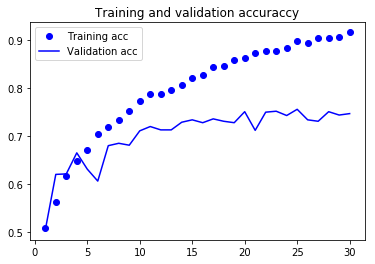

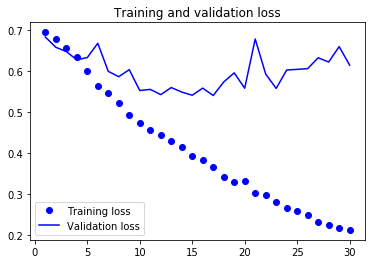

In [12]:
plot_model_performance(history)